In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
import geopandas as gdp

from rasterio.transform import rowcol
from rasterio.windows import Window

# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx")
regions = gpd.read_file("Regiones/Regional.shp")


In [2]:
regions = regions.to_crs("EPSG:4326")
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()


In [51]:
# Pick an example fire event

fire_id = 1 # look at first event
example_fire = df.loc[fire_id]

fire_season = example_fire["FireSeason"]
folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }
#save paths to images
pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
fire_scar_vector_path = os.path.join(folder, example_fire["FireScarVectorName"])
fire_scar_path = os.path.join(folder, example_fire["FireScarImgName"])
severity_path = os.path.join(folder, example_fire["SeverityImgName"])

In [43]:
example_fire

index                                                             3
FireID                                                     ID100027
FireSeason                                                     2003
RegionCode                                                    CL-ML
Region_CONAF                                                  Maule
FireName_CONAF                                     LAS CATALINAS II
Area_CONAF [ha]                                                80.0
IgnitionDate_CONAF                                       2003-02-15
ControlDate_CONAF                                        2003-02-16
Latitude [°]                                               -35.5755
Longitude [°]                                              -72.1725
FireScar                                                          1
FolderLocation                            FireScar_CL-ML_Maule_2003
FireScarImgName           FireScar_CL-ML_ID100027_u400_20030215.tif
PreFireImgName             ImgPreF_CL-ML_ID10002

In [69]:
# Read fire scar shape file as geo data frame
fire_scar_vector = gdp.read_file(fire_scar_vector_path)
fire_scar_vector = fire_scar_vector.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)


In [53]:
fire_scar = rasterio.open(fire_scar_path)
severity = rasterio.open(severity_path)

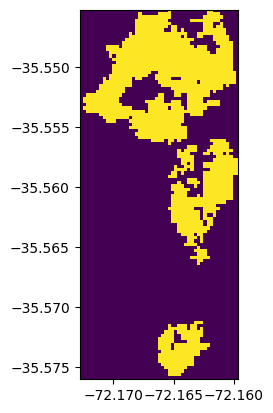

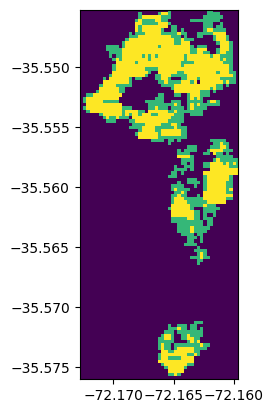

<Axes: >

In [54]:
show(fire_scar)
show(severity)

In [62]:
fire_scar_band = fire_scar.read(1)
fire_scar_band

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [63]:
severity_band = severity.read(1)
severity_band

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [67]:
# Center coordinates:
severity.xy(severity.height // 2, severity.width // 2)

(-72.16620326550597, -35.56075375291959)

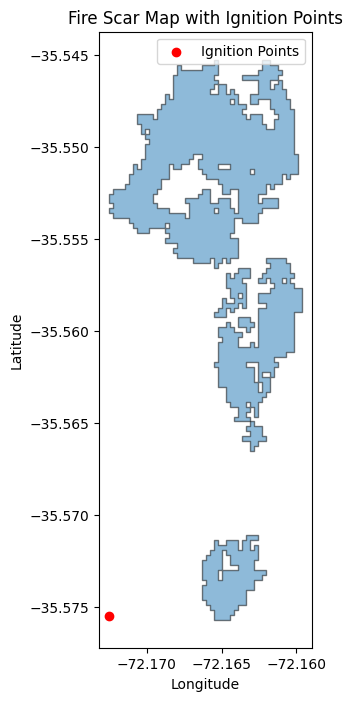

In [70]:
# Visualize fire scar with ignition point overlay

# Fire scar
ax = fire_scar_vector.plot(figsize=(8, 8), edgecolor="black", alpha=0.5)

# ignition point
plt.scatter(example_fire['Longitude [°]'],example_fire['Latitude [°]'], color='red', label='Ignition Points')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Fire Scar Map with Ignition Points")
plt.show()

In [17]:
pre_fire.transform

Affine(0.00026949458523585647, 0.0, -72.26874595518821,
       0.0, -0.00026949458523585647, -35.49647929434084)

/Users/abbystokes/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


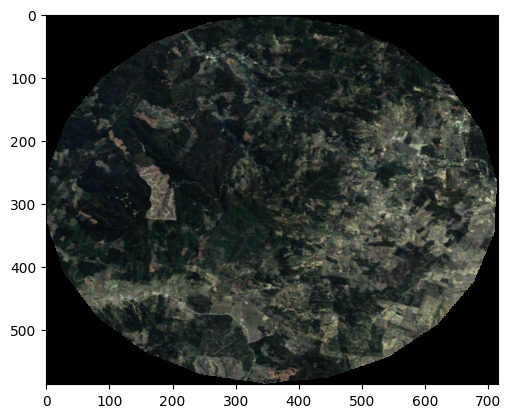

<Axes: >

In [71]:
from rasterio.plot import show, adjust_band
pre_fire = rasterio.open(pre_fire_path)
imgdata = np.array([adjust_band(pre_fire.read(i)) for i in (3,2,1)])
show(imgdata)  # factor 3 to increase brightness

/Users/abbystokes/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


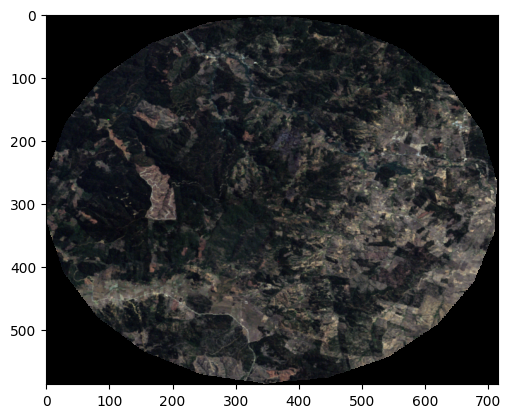

<Axes: >

In [30]:
post_fire = rasterio.open(post_fire_path)
imgdata = np.array([adjust_band(post_fire.read(i)) for i in (3,2,1)])
show(imgdata)

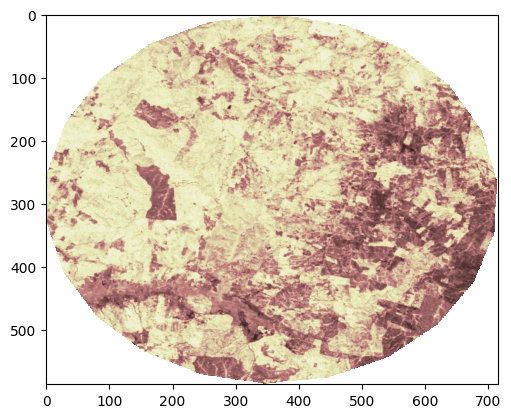

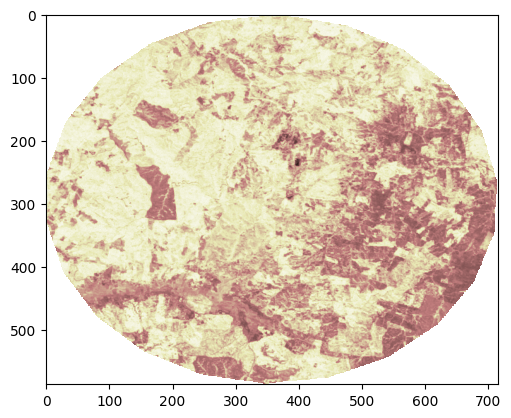

<Axes: >

In [78]:
show(pre_fire.read(8),cmap='pink')
show(post_fire.read(8),cmap='pink')

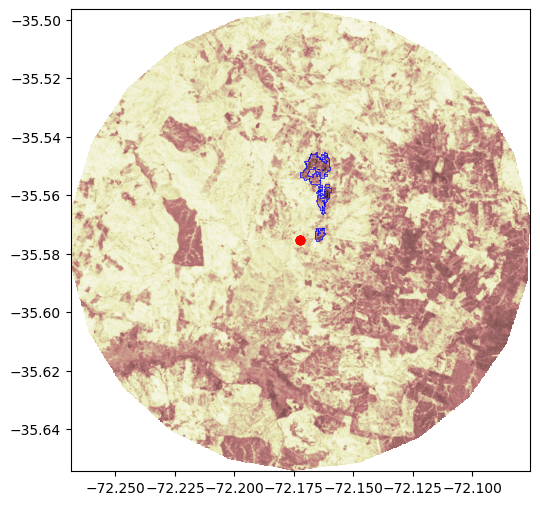

In [178]:
transform = pre_fire.transform

# Get raster bounds (left, bottom, right, top) in geographic coordinates
left, bottom, right, top = rasterio.transform.array_bounds(
    pre_fire.height, pre_fire.width, transform
)

# Read the 3rd band of the raster
fig, ax = plt.subplots(figsize=(10, 6))

# Set extent to real-world coordinates
show(post_fire.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top])


# Overlay fire scar on the same plot
fire_scar_vector.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)
plt.scatter(fire_scar_vector['IgnLon'], fire_scar_vector['IgnLat'], color='red', label='Ignition Point')



In [174]:
#cropping image to 512x512 centered on ignition point
# edge padding with nan

target_lat = fire_scar_vector['IgnLat'][0]
target_lon = fire_scar_vector['IgnLon'][0]

with rasterio.open(post_fire_path) as src:
    xsize, ysize = 512, 512
    
    target_x, target_y = src.index(target_lon, target_lat)
    xoff = target_x - xsize // 2
    yoff = target_y - ysize // 2

    window = Window(xoff, yoff, xsize, ysize).round_offsets()

    transform = src.window_transform(window) # Upadte transform
    crs = src.crs
    profile = src.profile
    profile.update({
        'height': ysize,
        'width': xsize,
        'transform': transform
    })

    data = src.read(window=window, boundless=True, fill_value=np.nan) # Pad outside values with nan

    # Write to new file
    with rasterio.open('output.tif', 'w', **profile) as dst:
        dst.write(data)


In [175]:
with rasterio.open('output.tif') as src:
    window = Window(xoff, yoff, xsize, ysize)
    cropped_data = src.read(window=window,boundless=True, fill_value=0)
    
    # Check the shape of the cropped data
    print(src.shape)

(512, 512)


In [176]:
cropped = rasterio.open('output.tif')
cropped.read(1)


array([[ nan,  nan,  nan, ..., 120., 120., 151.],
       [ nan,  nan,  nan, ..., 120., 120., 151.],
       [ nan,  nan,  nan, ..., 120., 151., 210.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

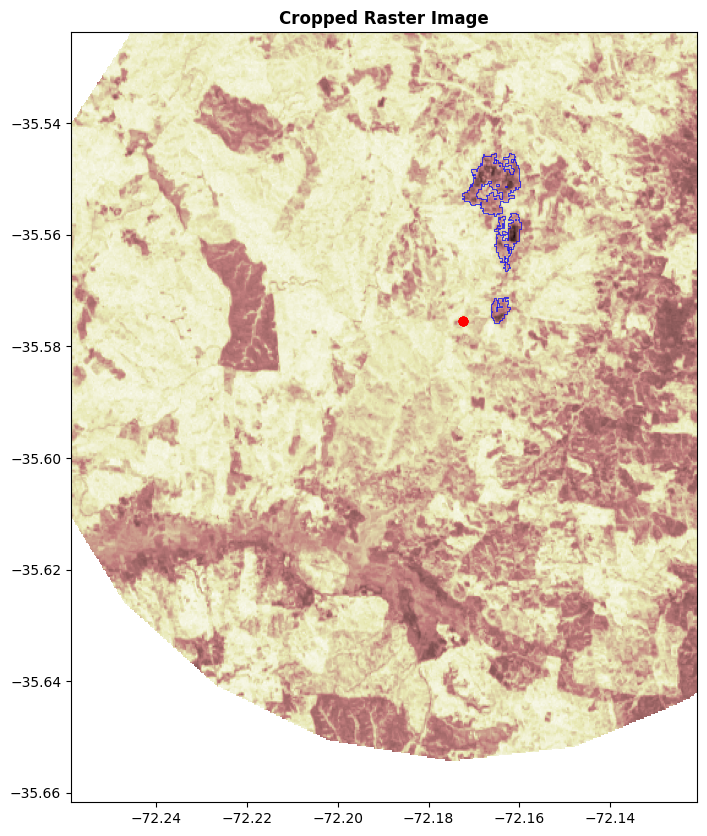

In [179]:
cropped_src = rasterio.open('output.tif')
transform = cropped_src.transform

# Get raster bounds (left, bottom, right, top) in geographic coordinates
left, bottom, right, top = rasterio.transform.array_bounds(
    cropped_src.height, cropped_src.width, transform
)

# Read the 3rd band of the raster
fig, ax = plt.subplots(figsize=(10, 10))

# Set extent to real-world coordinates
#show(pre_fire.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top])
show(cropped_src.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top], title="Cropped Raster Image")
fire_scar_vector.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=.5)
plt.scatter(fire_scar_vector['IgnLon'], fire_scar_vector['IgnLat'], color='red', label='Ignition Points')


In [174]:
target_lon

-72.0748